## Objective

You are a data scientist for a top movie studio.

After a series of box office flops, the producers at your
studio are starting to question their strategy and need a new direction. 

You suggest a new approach -
using data to determine what factors go into making a successful film.

Luckily, you have a dataset of over 5,000 films to mine for insights! The producers ask you to analyze the
data and present a report detailing your findings and recommendations on revamping the studio’s
strategy.

## Data
Attached is The Zebra movie dataset for use.
**Data Dictionary (selected columns)**
* num_critic_reviews - number of movie reviews written by critics
* num_user_reviews - number of movie reviews written by IMDB users
* num_users_voted - number of IMDB users that rated the film
* duration - the length of the film in minutes
* actor_n_facebook_likes - the number of likes on the actor’s Facebook page (we can assume this was
* measured before the film was released)
* gross - the film’s gross revenue
* movie_score - the film’s rating on a 1-10 scale by users that voted

### GOAL
* only supposed to spend **6-8 hours** on this

### Planned Breakdown
* **1 hour** setup (power point starter and code set)
  * includes some basic time for understanding
* 3 key insights - **4 hours**
* what we could explore, next steps, code checking, **1 hour**
* presentation build and script build and practice **2 hours**

In [1]:
# !pip install missingno # only used for this shouldn't be in requirements
# !pip install pingouin

In [23]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
import pandas as pd
import seaborn as sns


sys.tracebacklimit = 0 # easier to see problems

plt.rcParams["figure.figsize"] = (16, 12)



## Load Data

In [3]:

df = pd.read_csv("..//data/raw/the_zebra_movie_data.csv")

print(df.shape)
df.head(3).T

(5043, 26)


,0,1,2
color,Color,Color,Color
director_name,James Cameron,Gore Verbinski,Sam Mendes
num_critic_reviews,723.0,302.0,602.0
duration,178.0,169.0,148.0
director_facebook_likes,0.0,563.0,0.0
actor_3_facebook_likes,855.0,1000.0,161.0
actor_2_name,Joel David Moore,Orlando Bloom,Rory Kinnear
actor_1_facebook_likes,1000.0,40000.0,11000.0
gross,760505847.0,309404152.0,200074175.0
genres,Action|Adventure|Fantasy|Sci-Fi,Action|Adventure|Fantasy,Action|Adventure|Thriller


In [4]:
# fair amount of nulls 
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_reviews         4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_users_voted            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

## Profile Some Missing Data

In [20]:
# check the percent missing
# a note: facebook likes as 0 could also be a null, same for reviews and everything else
# would need to go to the source and understand them better

df.style.background_gradient()

df_zeros = df.replace(0, np.nan)

pd.concat([(df.isnull().sum() / len(df) * 100).to_frame(name="raw_nulls"),
            (df_zeros.isnull().sum() / len(df_zeros) * 100).\
            to_frame(name="with_zeros")], axis=1).sort_values(by="with_zeros", ascending=False) # zeros should be strictly greater than


,raw_nulls,with_zeros
movie_facebook_likes,0.000000,43.248067
director_facebook_likes,2.062265,20.047591
gross,17.529248,17.529248
budget,9.756098,9.756098
aspect_ratio,6.523895,6.523895
content_rating,6.008328,6.008328
plot_keywords,3.033908,3.033908
actor_3_facebook_likes,0.456078,2.220900
title_year,2.141582,2.141582
director_name,2.062265,2.062265


***

Data we definitely have - genres, num_users_voted, movie_title, movie_score

Data missing we should explore a bit, title_year, gross, budget

<Axes: >

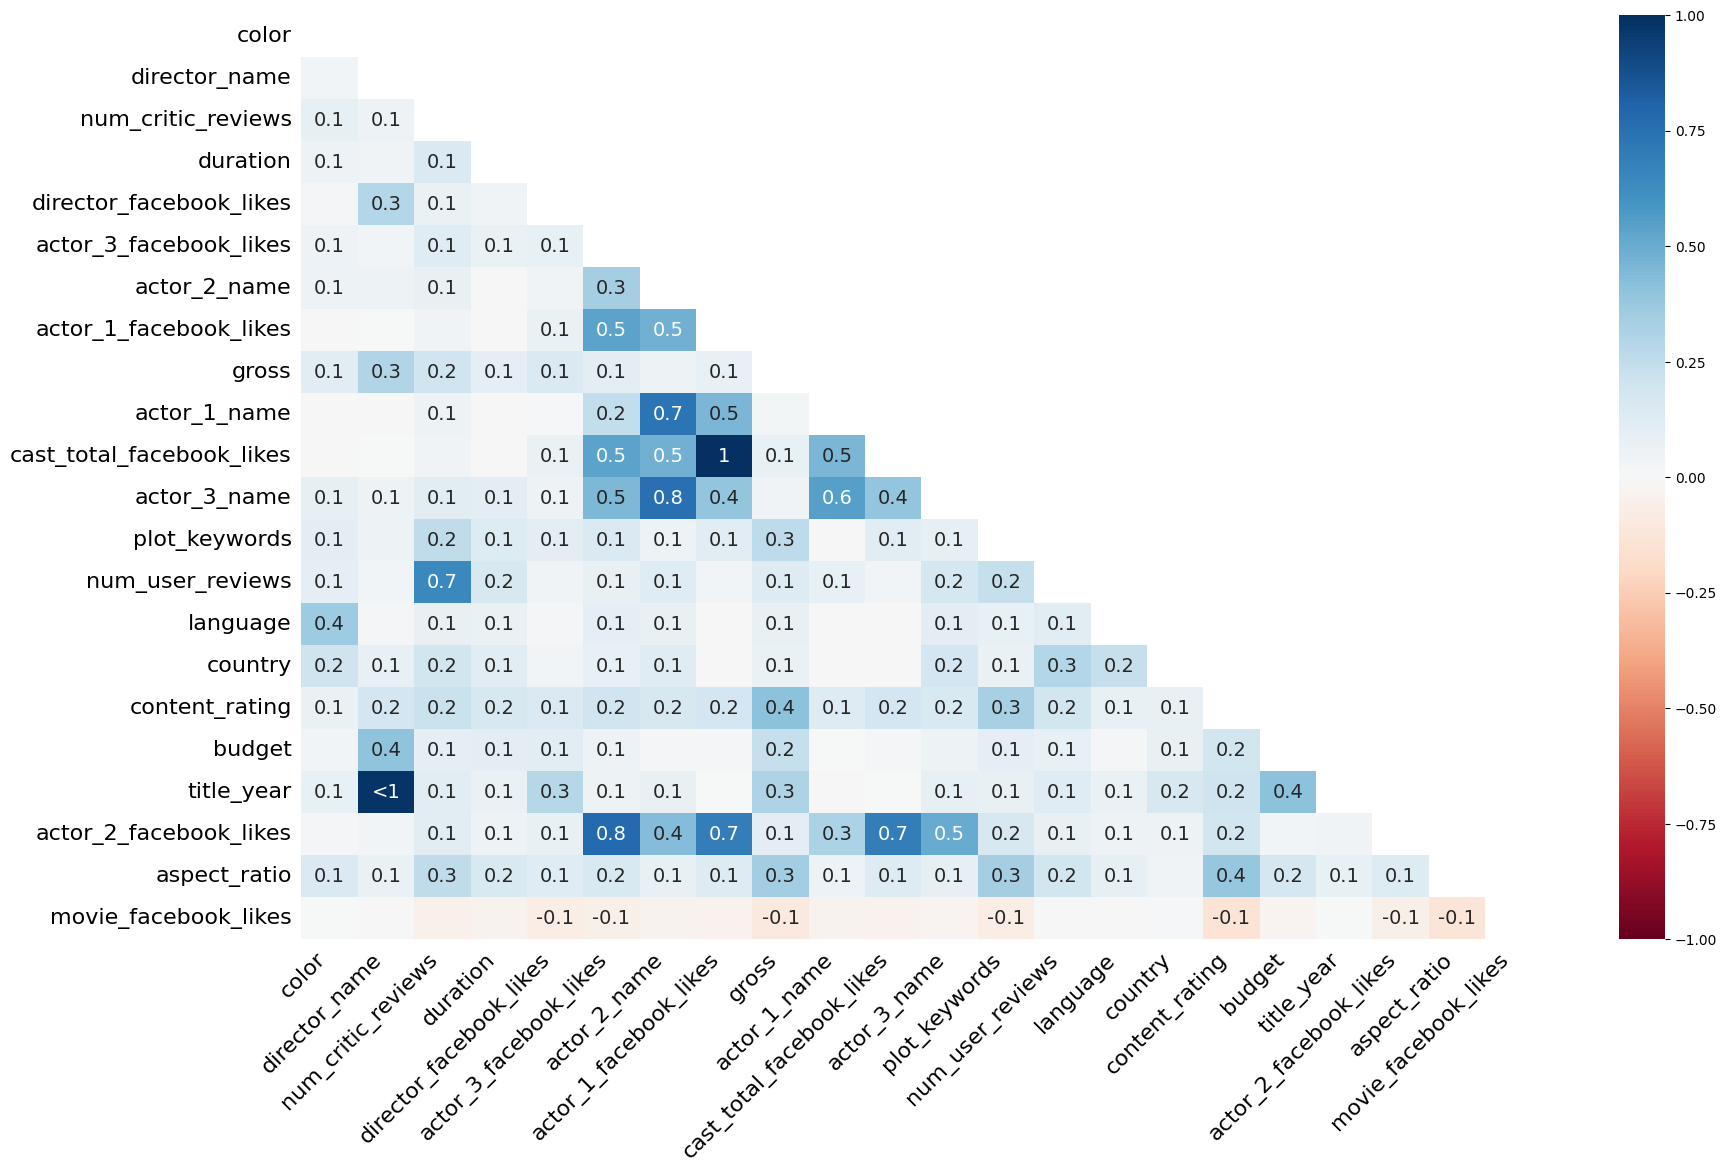

In [24]:
msno.heatmap(df_zeros)

## Movie Year

*  Understand where its missing
*  seems both random and for movies that are still in theaters (Force awakens came out end of 2015 and data through 2016 )

In [51]:

print("We have Movie data from {} to {}".format(df["title_year"].min(), df["title_year"].max()))



We have Movie data from 1916.0 to 2016.0


In [54]:
## what titles don't have years

df_null = df_zeros.loc[df["title_year"].isnull(), :]

print(df_null.shape, df.shape) # sanity check (108, 5k)

df_null["movie_title"] 

df_null.sort_values("num_users_voted", ascending=False)[["movie_title", "num_users_voted", "movie_score", "gross"]]
 # seems like some popular movies and some recent

(108, 26) (5043, 26)


,movie_title,num_users_voted,movie_score,gross
459,Daredevil,213483,8.8,NaN
4798,Heroes,202115,7.7,NaN
2952,Spartacus: War of the Damned,173172,8.6,NaN
3481,Fargo,170055,9.0,NaN
404,Hannibal,159910,8.6,NaN
...,...,...,...,...
2370,"Gone, Baby, Gone",29,6.6,NaN
2342,The Doombolt Chase,18,7.2,NaN
2765,Towering Inferno,10,9.5,NaN
4,Star Wars: Episode VII - The Force Awakens,8,7.1,NaN


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 364.9 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 1.4 MB/s eta 0:00:0000:010:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 2.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 2.9 MB/s eta 0:00:00a 0:00:01


In [53]:
import pingouin as pg

In [ ]:
pg.correlation(df_)

,movie_title,num_users_voted,movie_score,gross
459,Daredevil,213483,8.8,NaN
4798,Heroes,202115,7.7,NaN
2952,Spartacus: War of the Damned,173172,8.6,NaN
3481,Fargo,170055,9.0,NaN
404,Hannibal,159910,8.6,NaN
...,...,...,...,...
2370,"Gone, Baby, Gone",29,6.6,NaN
2342,The Doombolt Chase,18,7.2,NaN
2765,Towering Inferno,10,9.5,NaN
4,Star Wars: Episode VII - The Force Awakens,8,7.1,NaN


In [5]:
# facebook likes vs revenue
# revenue over time
# country and


